In [47]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import numpy as np
import matplotlib.pyplot as plt

/tmp/ipykernel_23524/4111778930.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


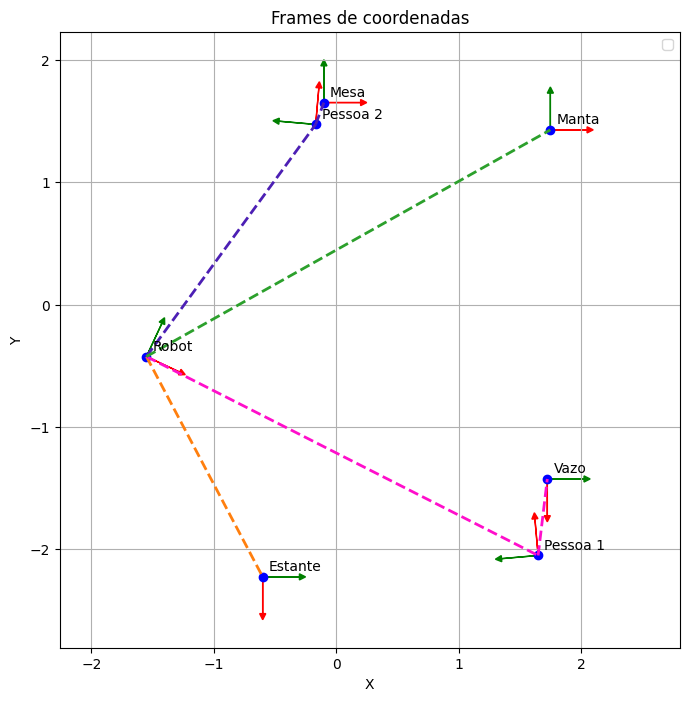

In [75]:
client = RemoteAPIClient()
sim = client.require("sim")
sim.setStepping(True)

class ObjetoCoppelia:
    def __init__(self, nome):
        self.nome = nome
        self.objeto = sim.getObject('/' + nome)  # pega o objeto do CoppeliaSim

    def getPosition(self):
        # Formato [x, y, \theta]
        posicao  = sim.getObjectPosition(self.objeto)
        orientacao = sim.getObjectOrientation(self.objeto)
        posicao = [posicao[0],posicao[1],orientacao[2]]

        return posicao
    
    def getObjetoOriginal(self):
        return self.objeto

def plot_intercessao(obj1,obj2,color):
    pos1 = obj1.getPosition()
    pos2 = obj2.getPosition()


    plt.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], color=color, linestyle='--', linewidth=2)


    


def plot_frame(objetos):

    frame_size = 0.3

    for nome, obj in objetos.items():
        pos = obj.getPosition()

        x, y, theta = pos[0], pos[1], pos[2]

        # direção dos vetores do plot
        u_x = frame_size  * np.cos(theta)
        v_x = frame_size  * np.sin(theta)
        u_y = -frame_size * np.sin(theta)
        v_y = frame_size  * np.cos(theta)

        plt.arrow(x, y, u_x, v_x, head_width=0.05, head_length=0.05, color='red')
        plt.arrow(x, y, u_y, v_y, head_width=0.05, head_length=0.05, color='green')
        plt.text(x + 0.05, y + 0.05, nome)
        plt.scatter(x, y, color='blue')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Frames de coordenadas')
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    # plt.show()



# Pegando objetos da cena
robot = ObjetoCoppelia("PioneerP3DX")
pessoa_1  = ObjetoCoppelia("Bill") 
pessoa_2 = ObjetoCoppelia("diningChair/Bill") 
vazo = ObjetoCoppelia("indoorPlant") 
estante = ObjetoCoppelia("rack") 
mesa = ObjetoCoppelia("customizableTable") 
manta = ObjetoCoppelia("Manta") 


objetos = {
    'Robot': robot,
    'Pessoa 1': pessoa_1,
    'Pessoa 2': pessoa_2,
    'Vazo': vazo,
    'Estante': estante,
    'Mesa': mesa,
    'Manta': manta
}


plt.figure(figsize=(8,8))
plot_frame(objetos)
plot_intercessao(robot, estante, "#ff7f0e")   
plot_intercessao(robot, pessoa_1, "#ff0ecb") 
plot_intercessao(pessoa_1, vazo, "#ff0ecb")  
plot_intercessao(robot, pessoa_2, "#4c1fb4") 
plot_intercessao(pessoa_2, mesa, "#4c1fb4")  
plot_intercessao(robot, manta, "#2ca02c")    



plt.show()



/tmp/ipykernel_23524/4111778930.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


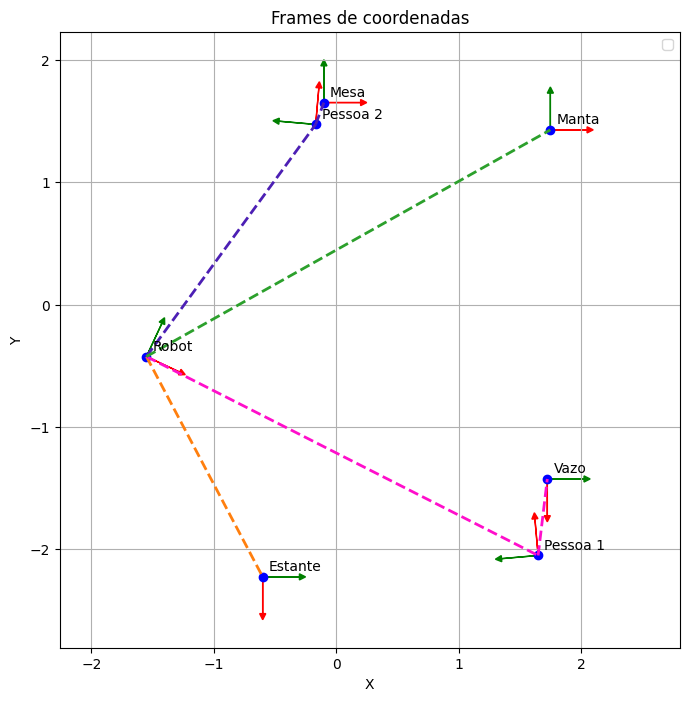

valores Pessoa 1 :1.6499999999999988 -2.05 1.658062789394722
valores conv Pessoa 1 :3.586939593845917 -0.1203717163642164 2.094395102393333
valores Pessoa 2 :-0.16741160453033582 1.4713953365152403 1.483499181291716
valores conv Pessoa 2 :0.45159932838935657 2.3030249651800148 1.919831494290327
valores Vazo :1.7250001192092896 -1.4250000596046448 -1.5707963267948994
valores conv Vazo :3.3907763975160314 0.47776701652410614 -1.1344640137962885
valores Estante :-0.5999999779463044 -2.225000015497292 -1.5707889358263265
valores conv Estante :1.6217052953549844 -1.2298666727372818 -1.1344566228277155
valores Mesa :-0.1 1.6500000000000001 -0.0
valores conv Mesa :0.4372133980911178 2.493385137625075 0.436332312998611
valores Manta :1.7500001508089298 1.4270073766354472 -0.0
valores conv Manta :2.2081236956555372 3.073129034573002 0.436332312998611


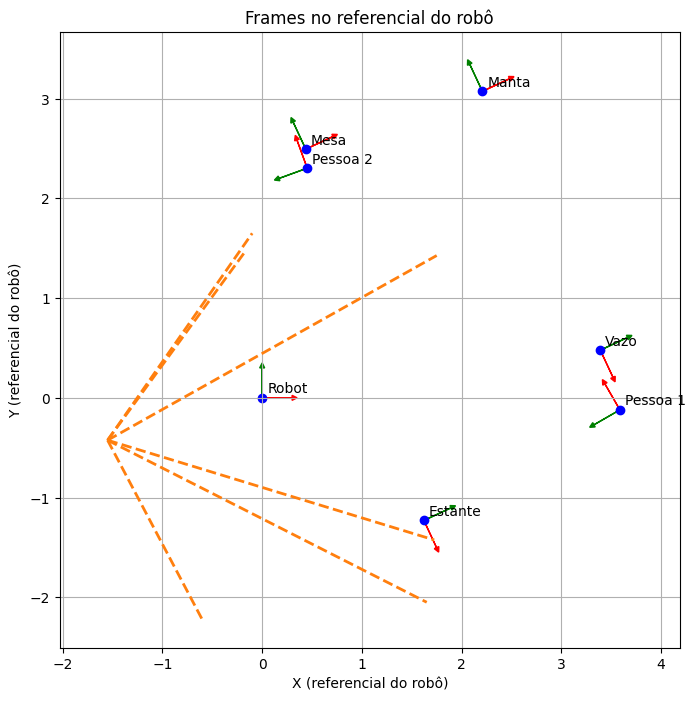

[3.5869395938459174, -0.12037171636421684, -0.1387930661439896]
[-0.0, 0.0, 2.0943951023933325]


In [81]:
import numpy as np

def global_to_robot(obj, robot):
    x_r, y_r, theta_r = robot.getPosition()
    x_o, y_o, theta_o = obj.getPosition()

    # Matriz homogênea do objeto no global
    T_obj = np.array([
        [np.cos(theta_o), -np.sin(theta_o), x_o],
        [np.sin(theta_o),  np.cos(theta_o), y_o],
        [0, 0, 1]
    ])

    # Matriz inversa do robô (global -> robô)
    T_robot_inv = np.array([
        [np.cos(theta_r), np.sin(theta_r), -x_r*np.cos(theta_r) - y_r*np.sin(theta_r)],
        [-np.sin(theta_r), np.cos(theta_r), x_r*np.sin(theta_r) - y_r*np.cos(theta_r)],
        [0, 0, 1]
    ])

    # Transformação do objeto no referencial do robô
    T_obj_robot = T_robot_inv @ T_obj

    # Posição
    x, y = T_obj_robot[0, 2], T_obj_robot[1, 2]

    # Orientação relativa: theta_obj - theta_robot
    theta_rel = np.arctan2(T_obj_robot[1, 0], T_obj_robot[0, 0])

    return x, y, theta_rel



def plot_frame_local(objetos, robot):
    frame_size = 0.3
    for nome, obj in objetos.items():
        if obj == robot:
            x, y, theta = 0, 0, 0  # o robô é a origem do sistema local
        else:
            pos = obj.getPosition()
            x, y, theta = global_to_robot(obj, robot)
            print(f'valores {nome} :{pos[0]} {pos[1]} {pos[2]}')
            print(f'valores conv {nome} :{x} {y} {theta}')
            # print(f"api {sim.getObjectPosition(obj, robot)}")

        plot_intercessao(robot, obj, "#ff7f0e")   

        # Vetores locais
        u_x = frame_size * np.cos(theta)
        v_x = frame_size * np.sin(theta)
        u_y = -frame_size * np.sin(theta)
        v_y = frame_size * np.cos(theta)

        plt.arrow(x, y, u_x, v_x, head_width=0.05, head_length=0.05, color='red')
        plt.arrow(x, y, u_y, v_y, head_width=0.05, head_length=0.05, color='green')
        plt.text(x + 0.05, y + 0.05, nome)
        plt.scatter(x, y, color='blue')

    plt.xlabel('X (referencial do robô)')
    plt.ylabel('Y (referencial do robô)')
    plt.title('Frames no referencial do robô')
    plt.grid(True)
    plt.axis('equal')
    plt.show()



plt.figure(figsize=(8,8))
plot_frame(objetos)
plot_intercessao(robot, estante, "#ff7f0e")   
plot_intercessao(robot, pessoa_1, "#ff0ecb") 
plot_intercessao(pessoa_1, vazo, "#ff0ecb")  
plot_intercessao(robot, pessoa_2, "#4c1fb4") 
plot_intercessao(pessoa_2, mesa, "#4c1fb4")  
plot_intercessao(robot, manta, "#2ca02c")    



plt.show()

plt.figure(figsize=(8,8))
plot_frame_local(objetos,robot)


print(sim.getObjectPosition(pessoa_1.getObjetoOriginal(), robot.getObjetoOriginal()))
print(sim.getObjectOrientation(pessoa_1.getObjetoOriginal(), robot.getObjetoOriginal()))


In [ ]:

#limpar o codigo e deixar ele de forma reutilizavel






# Plot frames e pontos


# Linha do robô para pessoa 1
robot_pos = sim.getObjectPosition(robot)
pessoa1_pos = sim.getObjectPosition(pessoa_1)
plt.plot([robot_pos[0], pessoa1_pos[0]], [robot_pos[1], pessoa1_pos[1]], color='orange', linestyle='--', linewidth=2, label='Robot → Pessoa 1')





#lixo


# positionBill = sim.getObjectPosition(bill)

# pos = sim.getObjectPosition(bill, robot)






# print('SIM Pos: ', pos)


# print(positionBill)

# list position = sim.getObjectPosition(int bill, int relativeToObjectHandle = sim.handle_world)


# def Rz(theta):
  
#     return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
#                       [ np.sin(theta), np.cos(theta) , 0 ],
#                       [ 0            , 0             , 1 ]])


# # sim.startSimulation()
# # while (t := sim.getSimulationTime()) < 5:
# #     print(f"Simulation time: {t:.2f} [s]")
# #     sim.step()
# # sim.stopSimulation()

# # Handle para o ROBÔ

    
# # Handle para as juntas das RODAS
# wheel1 = sim.getObject('/' + robotname + '/wheel0_joint')
# wheel2 = sim.getObject('/' + robotname + '/wheel1_joint')
# wheel3 = sim.getObject('/' + robotname + '/wheel2_joint')



# objectHandle = sim.getObject("Bill")

# position = sim.getObjectPosition(2, relativeToObjectHandle = sim.handle_world)

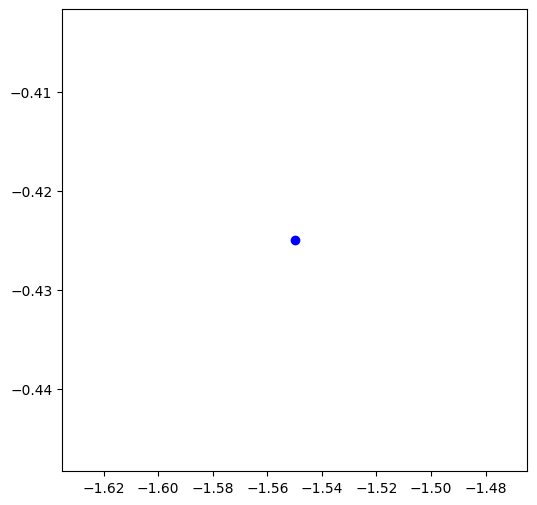

In [33]:
# pegue as posições globais usando a biblioteca

from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import numpy as np
import matplotlib.pyplot as plt


def plot_frame(Porg, R, c=['r', 'g']):
    
    axis_size = 3.0    
    axes = axis_size*R
    
    x_axis = np.array(axes[0:2,0])
    y_axis = np.array(axes[0:2,1])
        
    # X
    plt.quiver(*Porg[:2], *x_axis, color=c[0], angles='xy', scale_units='xy', scale=1)
    
    # Y
    plt.quiver(*Porg[:2], *y_axis, color=c[1], angles='xy', scale_units='xy', scale=1)






client = RemoteAPIClient()
sim = client.require("sim")
sim.setStepping(True)

robot = sim.getObject('/PioneerP3DX')
pessoa_1  = sim.getObject("/Bill")
pessoa_2 = sim.getObject("/diningChair/Bill")
vazo = sim.getObject("/indoorPlant")
estante = sim.getObject("/rack")
mesa = sim.getObject("/customizableTable")
manta = sim.getObject("/Manta")

robotPosition = sim.getObjectPosition(robot)


plt.figure(figsize=(6,6))
plt.scatter(robotPosition[0], robotPosition[1], color='blue', label='Pontos')

# # Opcional: adicionar setas indicando o ângulo theta
# for xi, yi, thetai in zip(robotPosition[0], robotPosition[1], 30):
#     dx = 0.5 * np.cos(thetai)  # tamanho da seta
#     dy = 0.5 * np.sin(thetai)
#     plt.arrow(xi, yi, dx, dy, head_width=0.1, head_length=0.1, color='red')

# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Plot de coordenadas [x, y, θ]')
# plt.grid(True)
# plt.axis('equal')
# plt.legend()
# plt.show()

# Plotando os referenciais
# plt.figure()
# plot_frame( sim.getObjectPosition(robot), sim.getObjectPosition(pessoa_1),['g','g'])




# Frame C->B
# pa_corg = np.array(Tac[:,3])
# pb_corg_aux = Rab @ pb_corg
# Rac = Tac[:3,:3]
# plot_frame(pa_corg, Rac, ['g', 'g'])
# plt.quiver(*pa_borg[:2], *pb_corg_aux[:2], color='g', angles='xy', scale_units='xy', scale=1)



# plot cada referencia usando matplot
# aplique as transformações compostas
# compare com os resultados obtido pela biblioteca 


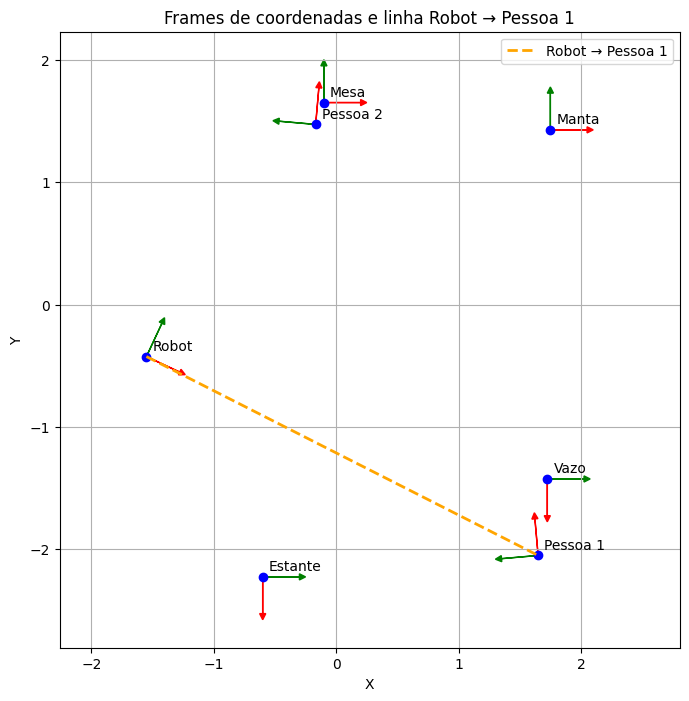

In [34]:
import matplotlib.pyplot as plt
import numpy as np

objetos = {
    'Robot': robot,
    'Pessoa 1': pessoa_1,
    'Pessoa 2': pessoa_2,
    'Vazo': vazo,
    'Estante': estante,
    'Mesa': mesa,
    'Manta': manta
}

frame_size = 0.3
plt.figure(figsize=(8,8))

# Plot frames e pontos
for nome, obj in objetos.items():
    pos = sim.getObjectPosition(obj)
    x, y = pos[0], pos[1]

    try:
        orientation = sim.getObjectOrientation(obj)
        theta = orientation[2]
    except:
        theta = 0

    u_x = frame_size * np.cos(theta)
    v_x = frame_size * np.sin(theta)
    u_y = -frame_size * np.sin(theta)
    v_y = frame_size * np.cos(theta)

    plt.arrow(x, y, u_x, v_x, head_width=0.05, head_length=0.05, color='red')
    plt.arrow(x, y, u_y, v_y, head_width=0.05, head_length=0.05, color='green')
    plt.text(x + 0.05, y + 0.05, nome)
    plt.scatter(x, y, color='blue')

# Linha do robô para pessoa 1
robot_pos = sim.getObjectPosition(robot)
pessoa1_pos = sim.getObjectPosition(pessoa_1)
plt.plot([robot_pos[0], pessoa1_pos[0]], [robot_pos[1], pessoa1_pos[1]], color='orange', linestyle='--', linewidth=2, label='Robot → Pessoa 1')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Frames de coordenadas e linha Robot → Pessoa 1')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()


## Transformações homogêneas


In [ ]:
pb = np.array([3, 7, 0, 1])

pa_borg = np.array([10, 5, 0])

theta = np.deg2rad(30)
Rab = Rz(theta)

# Concatena o vetor origem ao final (coluna)
Tab = np.column_stack((Rab, pa_borg))
print(Tab)

# Concatena o vetor auxiliar embaixo (linha)
aux = np.array([0, 0, 0, 1])
Tab = np.row_stack((Tab, aux))
print(Tab)

pa = Tab @ pb
print(pa)


# Plotando os referenciais
plt.figure()
plot_frame(pa_borg, Rab, ['g', 'g'])

# Vetor Pa_borg
pa_org = np.array([0, 0])
plt.quiver(*pa_org[:2], *pa_borg[:2], color='g', angles='xy', scale_units='xy', scale=1)

# Vetor Pb
pb_aux = Rab @ pb[:3]
plt.quiver(*pa_borg[:2], *pb_aux[:2], color='g', angles='xy', scale_units='xy', scale=1)

# Vetor Pa
plt.quiver(*pa_org[:2], *pa[:2], color='b', angles='xy', scale_units='xy', scale=1)

plt.plot(pa[0], pa[1], 'o', color='b')

plt.axis('scaled')
plt.axis((0, 14, 0, 14))

## Transformações compostas

In [ ]:
# Vetor auxiliar
aux = np.array([0, 0, 0, 1])

pc = np.array([2, 2, 0, 1])

aorg = np.array([0, 0])


# Definindo Tbc
pb_corg = np.array([0, -6, 0])
Rbc = Rz(np.deg2rad(-45))
Tbc = np.column_stack((Rbc, pb_corg))
Tbc = np.row_stack((Tbc, aux))

# Definindo Tab
pa_borg = np.array([5, 10, 0])
Rab = Rz(np.deg2rad(45))
Tab = np.column_stack((Rab, pa_borg))
Tab = np.row_stack((Tab, aux))


# Definindo Tac
Tac = Tab @ Tbc


# Plotando os referenciais
plt.figure()

# Frame C->B
pa_corg = np.array(Tac[:,3])
pb_corg_aux = Rab @ pb_corg
Rac = Tac[:3,:3]
plot_frame(pa_corg, Rac, ['g', 'g'])
plt.quiver(*pa_borg[:2], *pb_corg_aux[:2], color='g', angles='xy', scale_units='xy', scale=1)

# Frame B->A
plot_frame(pa_borg, Rab, ['b', 'b'])
plt.quiver(*aorg, *pa_borg[:2], color='b', angles='xy', scale_units='xy', scale=1)


# Calculando pa
pa = Tac @ pc
print(pa)

plt.plot(pa[0], pa[1], 'o', color='darkorange')
plt.quiver(*aorg, *pa[:2], color='darkorange', angles='xy', scale_units='xy', scale=1)

plt.axis('scaled')
plt.axis((0, 15, 0, 15))